In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import torch.optim as optim
import torch.nn as nn

from qibo import Circuit, gates, hamiltonians, set_backend, construct_backend

from qiboml.models.encoding import PhaseEncoding
from qiboml.models.decoding import Expectation
from qiboml.interfaces.pytorch import QuantumModel
from qiboml.operations.differentiation import PSR, Jax

2025-05-16 10:52:56.932989: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747385576.952368   43518 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747385576.958127   43518 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747385576.972702   43518 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747385576.972726   43518 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747385576.972729   43518 computation_placer.cc:177] computation placer alr

In [3]:
class ScaledTanhEncoding(nn.Module):
    """Non-linear encoding layer using f(x) = (pi/2) * (tanh(a * x + b) + 1)"""
    def _init_(self):
        super()._init_()
        self.a = nn.Parameter(torch.tensor(np.random.randn()))
        self.b = nn.Parameter(torch.tensor(np.random.randn()))

    def forward(self, x):
        return (torch.pi / 2) * (torch.tanh(self.a * x + self.b) + 1)


[Qibo 0.2.19|INFO|2025-05-16 10:54:41]: Using qiboml (pytorch) backend on cpu


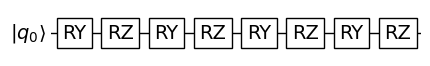

In [7]:
set_backend("qiboml", platform="pytorch")

nqubits = 1
nlayers = 4

gates_list = []
for _ in range(nlayers):
    gates_list.extend([gates.RY, gates.RZ])

class LinEncoding(nn.Module):
    """Activation function which helps in giving more sensitivity around zero."""
    def __init__(self):
        super(LinEncoding, self).__init__()
        self.param1 = nn.Parameter(torch.tensor(np.random.randn()))
        self.param2 = nn.Parameter(torch.tensor(np.random.randn()))
    
    def forward(self, x):
        return self.param1 * x + self.param2 

class ScaledTanhEncoding(nn.Module):
    """Non-linear encoding layer using f(x) = (pi/2) * (tanh(a * x + b) + 1)"""
    def __init__(self):
        super().__init__()
        self.p1 = nn.Parameter(torch.tensor(np.random.randn()))
        self.p2 = nn.Parameter(torch.tensor(np.random.randn()))

    def forward(self, x):
        return (torch.pi / 2) * (torch.tanh(self.p1 * x + self.p2) + 1)

circuit_structure = []
for k in range(2 * nlayers):
    circuit_structure.append(
        PhaseEncoding(
            nqubits=nqubits,
            encoding_gate=gates_list[k],
            encoding_rule=ScaledTanhEncoding()
        )
    )

# Decoding layer
decoding_circ = Expectation(
    nqubits=nqubits, 
    backend=construct_backend("qiboml", platform="pytorch")
)
# The whole model
model = QuantumModel(
    circuit_structure=circuit_structure,
    decoding=decoding_circ,
)

_ = model.draw()

In [8]:
model(torch.tensor(0.5))

tensor([[-0.2908]], dtype=torch.float64, grad_fn=<ViewBackward0>)

In [9]:
# Prepare the training dataset (using f(x) = sin(x) as the target function)
def f(x):
    return np.exp(-100 * x**2)

num_samples = 30
x_train = torch.linspace(-1, 1 * np.pi, num_samples, dtype=torch.float64).unsqueeze(1)
y_train = f(x_train)

y_train = 2 * ( (y_train - min(y_train)) / (max(y_train) - min(y_train)) - 0.5 )

/tmp/ipykernel_43518/4177352912.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return np.exp(-100 * x**2)


In [10]:
optimizer = optim.Adam(model.parameters(), lr=0.1)
criterion = nn.MSELoss()

In [11]:
epochs = 150
for epoch in range(epochs):
    optimizer.zero_grad()
    # Use torch.stack to get a tensor of shape (100, 1, 1)
    y_pred = torch.stack([model(x) for x in x_train])
    # Remove the extra singleton dimension so that y_pred has shape (100, 1)
    y_pred = y_pred.squeeze(-1)
    
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item()}")

Epoch 0: Loss = 0.43326687095072436
Epoch 10: Loss = 0.09300460665961802
Epoch 20: Loss = 0.07425949452394366
Epoch 30: Loss = 0.05113369700618761
Epoch 40: Loss = 0.03155547188785586
Epoch 50: Loss = 0.016159165187507034
Epoch 60: Loss = 0.006731749857651871
Epoch 70: Loss = 0.0028512539789306525
Epoch 80: Loss = 0.0013262792301996578
Epoch 90: Loss = 0.0006799866197943002
Epoch 100: Loss = 0.00039044099141931967
Epoch 110: Loss = 0.00024542513229722283
Epoch 120: Loss = 0.0001665639177986766
Epoch 130: Loss = 0.00012070314681404505
Epoch 140: Loss = 9.22423861532966e-05


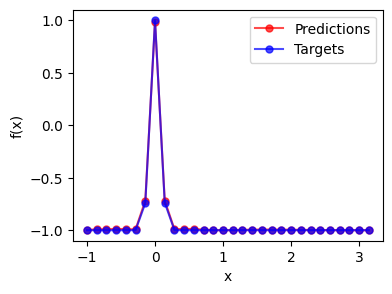

In [12]:
plt.figure(figsize=(4, 4 * 6 / 8), dpi=100)
plt.plot(
    x_train, 
    y_pred.detach().numpy(), 
    marker=".",
    markersize=10,
    color="red", 
    label="Predictions",
    alpha=0.7
)
plt.plot(
    x_train, 
    y_train,
    marker=".",
    markersize=10,
    color="blue", 
    label="Targets",
    alpha=0.7
)
plt.xlabel(r"x")
plt.ylabel(r"f(x)")
plt.legend()
plt.show()